In [1]:
from monai.utils import set_determinism, first
# from monai.transforms import (
#     EnsureChannelFirstD,
#     Compose,
#     LoadImageD,
#     RandRotateD,
#     RandZoomD,
#     ScaleIntensityRanged,
# )
# import monai
from monai.data import DataLoader, Dataset, CacheDataset
# from monai.config import print_config, USE_COMPILED
# from monai.networks.nets import GlobalNet, LocalNet
# from monai.networks.blocks import Warp
# from monai.apps import MedNISTDataset
import torch.nn.functional as F
from piqa import SSIM

# from glob import glob
# import cv2
# import torchmetrics

# from torch.autograd import Variable

# from scipy.spatial.distance import directed_hausdorff
# import pandas as pd


import numpy as np
import torch, torchinfo, torchvision
from glob import glob
import cv2

import torch.nn as nn
# from torch.nn import MSELoss
# import matplotlib.pyplot as plt
# import os
# import tempfile
from monai.losses import BendingEnergyLoss, MultiScaleLoss, DiceLoss
from monai.metrics import *

# import torch
# import torch.nn as nn
# import torchvision.transforms as transforms
# import torch.optim as optim
# import torchvision.datasets as datasets
# import imageio
# import numpy as np
# import matplotlib
# from torchvision.utils import make_grid, save_image
# from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
# from tqdm import tqdm
# matplotlib.style.use('ggplot')

# print_config()
# set_determinism(42)

/home/yaplab2/anaconda3/envs/phd/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print('How many GPUs = ' + str(torch.cuda.device_count()))

#checking for device

device=torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print(device)


if not torch.cuda.is_available():
    raise Exception("GPU not availalbe. CPU training will be too slow.")

print("device name", torch.cuda.get_device_name(0))

How many GPUs = 4
cuda:2
device name NVIDIA GeForce RTX 3090 Ti


In [3]:
img_size = 512
EP = 30
num_workers = 8

TrImage = "data_VAE/aug_train/*.png"
ValImage = "data_VAE/aug_val/*.png"

In [4]:
class EchoDatasetMask(Dataset):
    def __init__(self, images_path, labtozero):

        self.images_path = images_path
        self.labtozero = labtozero
        self.n_samples = len(images_path)

    def __getitem__(self, index):
        """ Reading image """
        image = cv2.imread(self.images_path[index], cv2.IMREAD_GRAYSCALE)
        
        if self.labtozero is not None:
            image [image==self.labtozero]=0
            
        image = cv2.resize(image,(img_size, img_size), interpolation=cv2.INTER_NEAREST)
        image = image/(image.max()) ## (512, 512, 3)
#         print(image.max())
#         image = image/(image.max()) ## (512, 512, 3)
        image = np.expand_dims(image, axis=0)
        image = image.astype(np.float32)
        self.images_path[index]
        return image

    def __len__(self):
        return self.n_samples
    
def get_batches_mask(_dir,
                     _labtozero,
                     batch_size,
                     num_workers,
                     pin_memory):
    
    _data = EchoDatasetMask(images_path=_dir, labtozero = _labtozero)

    _loader = DataLoader(_data,
                              batch_size=batch_size,
                              num_workers=num_workers,
                              pin_memory=pin_memory,
                              shuffle=True)

    return _loader

print(len(sorted(glob(TrImage))))
print(len(sorted(glob(ValImage))))

62298
1398


_train_mask_ shape: torch.Size([512, 512])
_val_mask_ shape: torch.Size([512, 512])
_train_mask_ range: 1.0 0.0 [0. 1.]
_val_mask_ range: 1.0 0.0 [0. 1.]


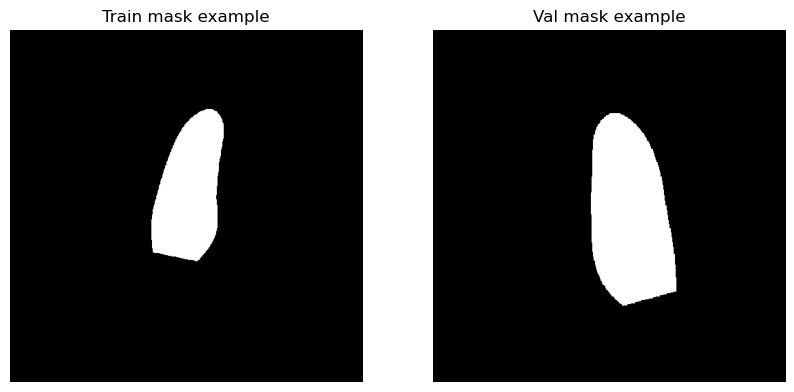

In [5]:
train_mask_LV = get_batches_mask(_dir = sorted(glob(TrImage)),
                                            _labtozero = 100,
                                            batch_size = 128,
                                            num_workers = num_workers,
                                            pin_memory = True)



val_mask_LV = get_batches_mask(_dir = sorted(glob(ValImage)),
                                          _labtozero = 100,
                                          batch_size = 8,
                                          num_workers = num_workers,
                                          pin_memory = True)

dataloaders = {'_train': train_mask_LV, '_val': val_mask_LV}


_train_mask_ = first(dataloaders["_train"])[0][0]
_val_mask_ = first(dataloaders["_val"])[0][0]

print(f"_train_mask_ shape: {_train_mask_.shape}")
print(f"_val_mask_ shape: {_val_mask_.shape}")


print(f"_train_mask_ range: {_train_mask_.max()} {_train_mask_.min()} {np.unique(_train_mask_)}")
print(f"_val_mask_ range: {_val_mask_.max()} {_val_mask_.min()} {np.unique(_val_mask_)}")

plt.figure("check", (10, 5))

plt.subplot(1, 2, 1)
plt.title("Train mask example")
plt.imshow(_train_mask_, cmap="gray")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Val mask example")
plt.imshow(_val_mask_, cmap="gray")
plt.axis('off')

plt.show()

_train_mask_ shape: torch.Size([512, 512])
_val_mask_ shape: torch.Size([512, 512])
_train_mask_ range: 1.0 0.0 [0. 1.]
_val_mask_ range: 1.0 0.0 [0. 1.]


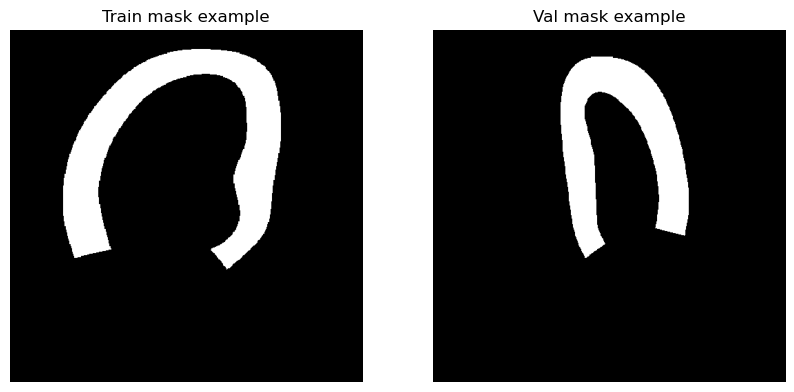

In [6]:
train_mask_Myo = get_batches_mask(_dir = sorted(glob(TrImage)),
                                            _labtozero = 200,
                                            batch_size = 128,
                                            num_workers = num_workers,
                                            pin_memory = True)



val_mask_Myo = get_batches_mask(_dir = sorted(glob(ValImage)),
                                          _labtozero = 200,
                                          batch_size = 8,
                                          num_workers = num_workers,
                                          pin_memory = True)

dataloaders = {'_train': train_mask_Myo, '_val': val_mask_Myo}


_train_mask_ = first(dataloaders["_train"])[0][0]
_val_mask_ = first(dataloaders["_val"])[0][0]

print(f"_train_mask_ shape: {_train_mask_.shape}")
print(f"_val_mask_ shape: {_val_mask_.shape}")


print(f"_train_mask_ range: {_train_mask_.max()} {_train_mask_.min()} {np.unique(_train_mask_)}")
print(f"_val_mask_ range: {_val_mask_.max()} {_val_mask_.min()} {np.unique(_val_mask_)}")

plt.figure("check", (10, 5))

plt.subplot(1, 2, 1)
plt.title("Train mask example")
plt.imshow(_train_mask_, cmap="gray")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Val mask example")
plt.imshow(_val_mask_, cmap="gray")
plt.axis('off')

plt.show()

In [7]:
trainData = {'Myo': train_mask_Myo, 'LV': train_mask_LV}
valData = {'Myo': val_mask_Myo, 'LV': val_mask_LV}

In [8]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):  
        super(VariationalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=1)  
        self.linear1 = nn.Linear(img_size//8*img_size//8*32, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device) # hack to get sampling on the GPU
        self.N.scale = self.N.scale.to(device)
        self.kl = 0

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        # print(f'XX = {x.shape}')
        x = torch.flatten(x, start_dim=1)
        # print(f'XX = {x.shape}')
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z      

In [9]:
class Decoder(nn.Module):
    
    def __init__(self, latent_dims):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            nn.Linear(128, img_size//8*img_size//8*32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, img_size//8, img_size//8))
        
        self.m = nn.Softmax(dim=1)

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
#         x = self.m(x)
        return x

In [10]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
#         print(f'Latent dim = {z.shape}')
#         print(f'Latent Value = {z}')
        return self.decoder(z)

In [11]:
### Set the random seed for reproducible results
torch.manual_seed(0)

d = 8

Myo_VAE = VariationalAutoencoder(latent_dims=d)
Myo_VAE.to(device)
Myo_VAE.load_state_dict(torch.load('Myo_VAE_'+ str(img_size) + '_.pth', map_location= device))

# torchinfo.summary(Myo_VAE, input_size=(2, 1, 512, 512), depth=100)



<All keys matched successfully>

In [12]:
lr = 1e-3 

optim_Myo_VAE = torch.optim.Adam(Myo_VAE.parameters(), lr=lr, weight_decay=1e-5)


In [13]:
### Training function

class SSIMLoss(SSIM):
    def forward(self, x, y):
        return 1. - super().forward(x, y)
    

label_SSIM = SSIMLoss(n_channels=1).to(device) # .cuda() if you need GPU support

label_loss = DiceLoss()


def train_epoch(model, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    model.train()
    _loss = 0.0
    _loss_DSC = 0.0
    _loss_SSIM = 0.0
    _loss_KL = 0.0
    _loss_diff_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x in dataloader: 
        # Move tensor to the proper device
        x = x.to(device)
        x_hat = model(x)
        # Evaluate loss
        # x_o = x[8,:,:,:].reshape(512,512)
        # x_p = x_hat[8,:,:,:].reshape(512,512)

        # x_p[x_p<0.1]=0
        # x_p[x_p>0.9]=1


        # # print(x_o.shape)
        # # print(x_p.shape)
        # print(torch.unique(x_o, return_counts= True))
        # print(torch.unique(x_p, return_counts= True))
        
        diff_loss = ((x - x_hat)**2).sum()
        DSC = label_loss(x, x_hat)
        KL = model.encoder.kl
        SSIM = label_SSIM(x,x_hat)
        
        loss = KL + diff_loss + DSC + SSIM
    
#         print('------')
#         print(DSC)    
#         print(SSIM)
#         print(KL)
#         print(diff_loss)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print batch loss
#         print('\t partial train loss (single batch): %f' % (loss.item()))
        _loss+=loss.item()
        _loss_DSC+=DSC.item()
        _loss_SSIM+=SSIM.item()
        _loss_KL+=KL.item()
        _loss_diff_loss+=diff_loss.item()
        
        dice_metric(y_pred = x_hat, y=x)
            
    metric = dice_metric.aggregate().item()
    dice_metric.reset()
    print(f"Train mean dice: {metric:.4f}")
    L = len(dataloader.dataset)
#     print(_loss_DSC)
#     print(_loss_SSIM)

    return [_loss/L, _loss_DSC/L, _loss_SSIM/L, _loss_KL/L, _loss_diff_loss/L]

In [14]:
### Testing function
def test_epoch(model, device, dataloader):
    
    # Set evaluation mode for encoder and decoder
    model.eval()
    _loss = 0.0
    _loss_DSC = 0.0
    _loss_SSIM = 0.0
    _loss_KL = 0.0
    _loss_diff_loss = 0.0
    
    with torch.no_grad(): # No need to track the gradients
        for x in dataloader:
            # Move tensor to the proper device
            x = x.to(device)
            # Encode data
            encoded_data = model.encoder(x)
            # Decode data
            x_hat = model(x)         
            
            diff_loss = ((x - x_hat)**2).sum()
            DSC = label_loss(x, x_hat)
            KL = model.encoder.kl
            SSIM = label_SSIM(x,x_hat)

            loss = KL + diff_loss + DSC + SSIM
            
            _loss += loss.item()
            _loss_DSC+=DSC.item()
            _loss_SSIM+=SSIM.item()
            _loss_KL+=KL.item()
            _loss_diff_loss+=diff_loss.item()

        #     meandice_.extend((compute_meandice(y_pred = make_one_hot(x_hat, C=3), y=make_one_hot(x.to(device), C=3))).detach().cpu().numpy())
            
            dice_metric(y_pred = x_hat, y=x)
            
        metric = dice_metric.aggregate().item()
        dice_metric.reset()
        print(f"Val mean dice: {metric:.4f}")
        L = len(dataloader.dataset)
        # print(f'Mean dice = {np.mean(np.array(meandice_), axis=0)}')

    return [_loss/L, _loss_DSC/L, _loss_SSIM/L, _loss_KL/L, _loss_diff_loss/L, metric]

In [15]:
def plot_outputs(encoder, decoder, mask):
    plt.figure(figsize=(16,4.5))
    for image in mask:
#         print(image.size(0))
        encoder.eval() 
        decoder.eval()
        with torch.no_grad():
            rec_img  = decoder(encoder(image.to(device)))
            
            
        for i in range (image.size(0)):
            ax = plt.subplot(2,image.size(0),i+1)
            plt.imshow(image[i,:,:,:].reshape(img_size, img_size).cpu().squeeze().numpy(), cmap='gist_gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)  
            if i == image.size(0)//2:
                ax.set_title('Original images')
                
#             print(np.unique(rec_img[i,:,:,:].reshape(512,512).cpu().squeeze().numpy()))
                
            ax = plt.subplot(2, image.size(0), i + 1 + image.size(0))
            plt.imshow(rec_img[i,:,:,:].reshape(img_size, img_size).cpu().squeeze().numpy(), cmap='gist_gray')  
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)  
            # print(np.unique(rec_img[i,:,:,:].reshape(512,512).cpu().squeeze().numpy()))
            if i == image.size(0)//2:
                ax.set_title('Reconstructed images')
                
        plt.show()   
        break    


<<<----------------------- EPOCH 1/30 ------------------------->>>
<<<----------------------- MYO ------------------------->>>


y_pred should be a binarized tensor.


Train mean dice: 0.9630
Val mean dice: 0.9207
Valid DSC improved from 0.0000 to 0.9207! Best model is saving as---> Myo_VAE_512_.pth

 MYO train loss=1133.949 	 and 	 MYO val loss=4043.925
Best val DSC: 0.9207 at epoch number of 1


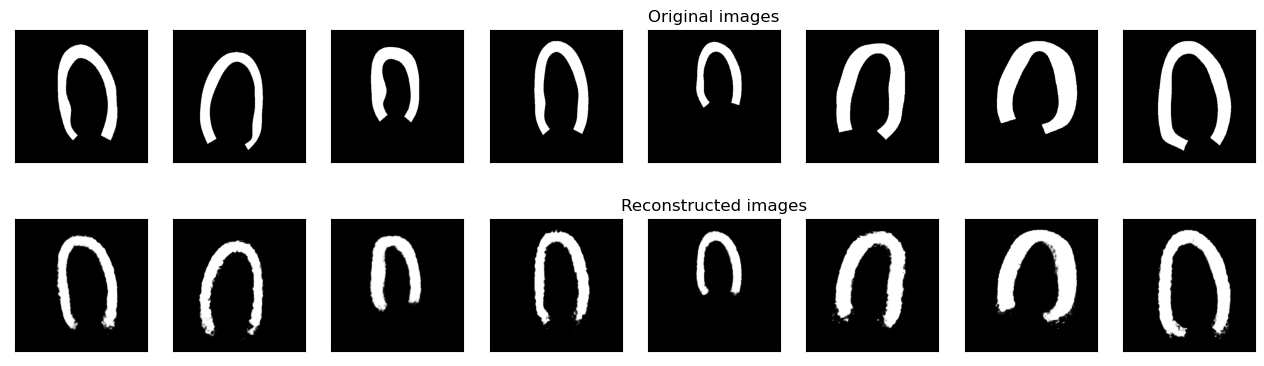


<<<----------------------- EPOCH 2/30 ------------------------->>>
<<<----------------------- MYO ------------------------->>>
Train mean dice: 0.9634
Val mean dice: 0.9198

 MYO train loss=1117.054 	 and 	 MYO val loss=4087.198
Best val DSC: 0.9207 at epoch number of 1


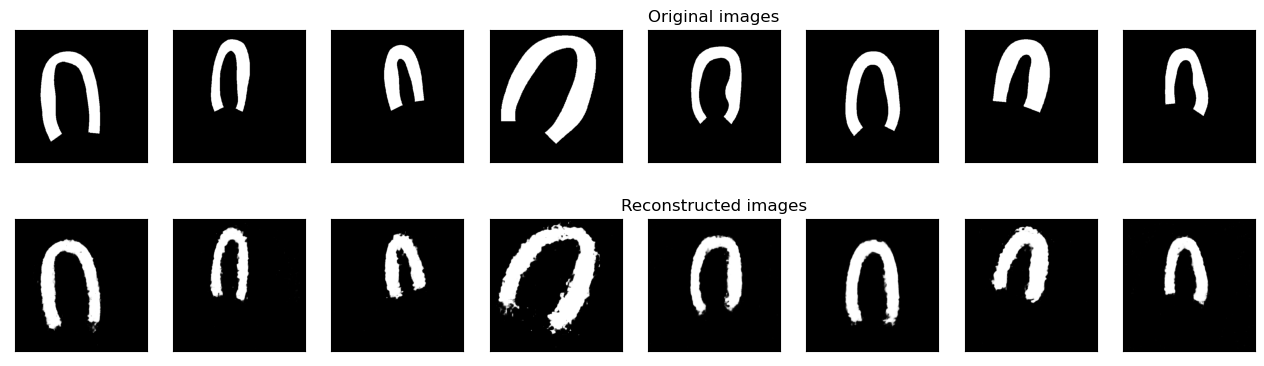


<<<----------------------- EPOCH 3/30 ------------------------->>>
<<<----------------------- MYO ------------------------->>>
Train mean dice: 0.9636
Val mean dice: 0.9204

 MYO train loss=1109.595 	 and 	 MYO val loss=4039.128
Best val DSC: 0.9207 at epoch number of 1


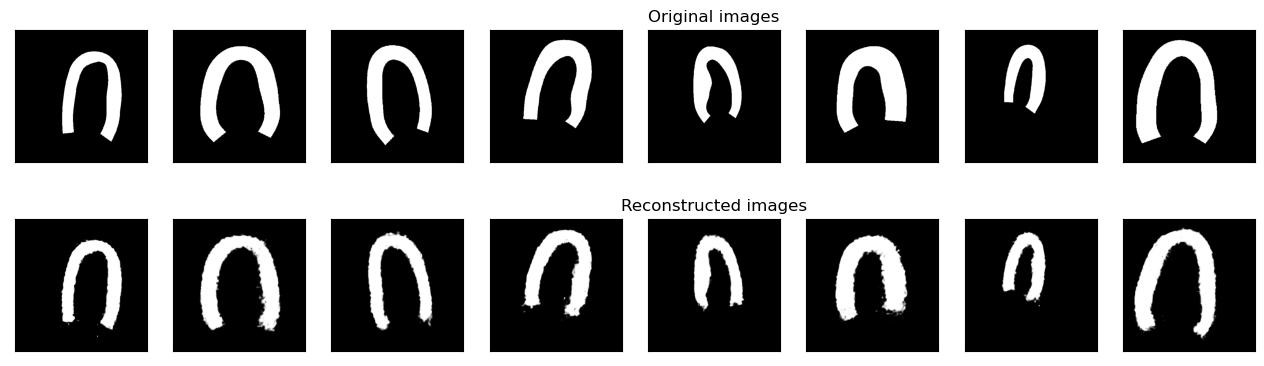


<<<----------------------- EPOCH 4/30 ------------------------->>>
<<<----------------------- MYO ------------------------->>>
Train mean dice: 0.9637
Val mean dice: 0.9200

 MYO train loss=1107.766 	 and 	 MYO val loss=4049.429
Best val DSC: 0.9207 at epoch number of 1


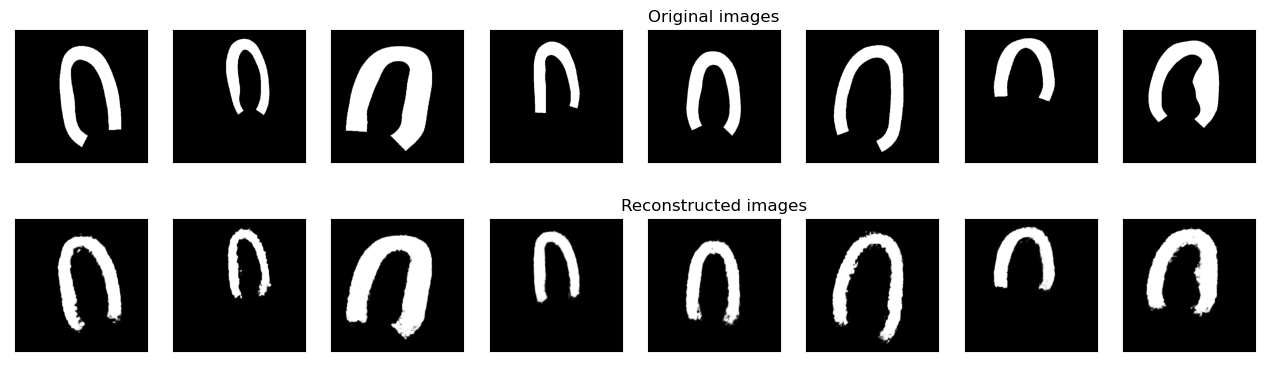


<<<----------------------- EPOCH 5/30 ------------------------->>>
<<<----------------------- MYO ------------------------->>>
Train mean dice: 0.9636
Val mean dice: 0.9206

 MYO train loss=1113.326 	 and 	 MYO val loss=4048.355
Best val DSC: 0.9207 at epoch number of 1


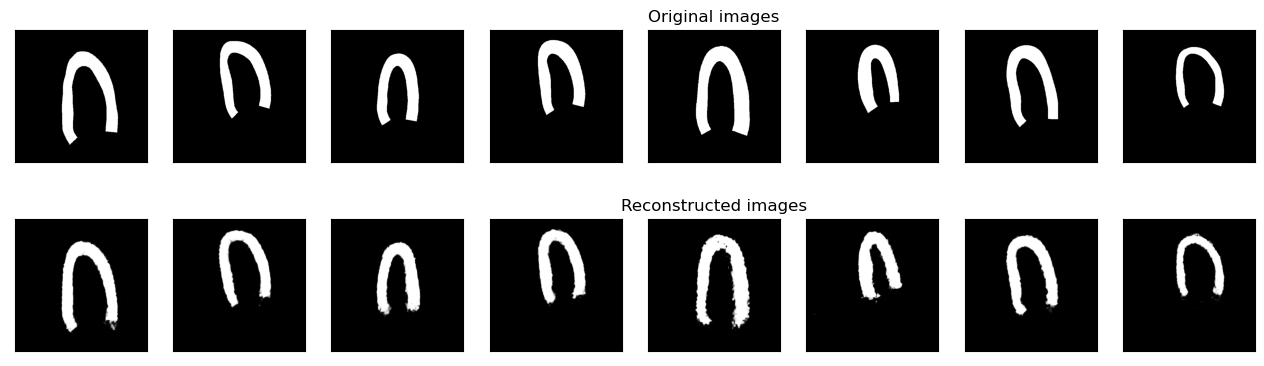


<<<----------------------- EPOCH 6/30 ------------------------->>>
<<<----------------------- MYO ------------------------->>>
Train mean dice: 0.9639
Val mean dice: 0.9201

 MYO train loss=1100.413 	 and 	 MYO val loss=4071.330
Best val DSC: 0.9207 at epoch number of 1


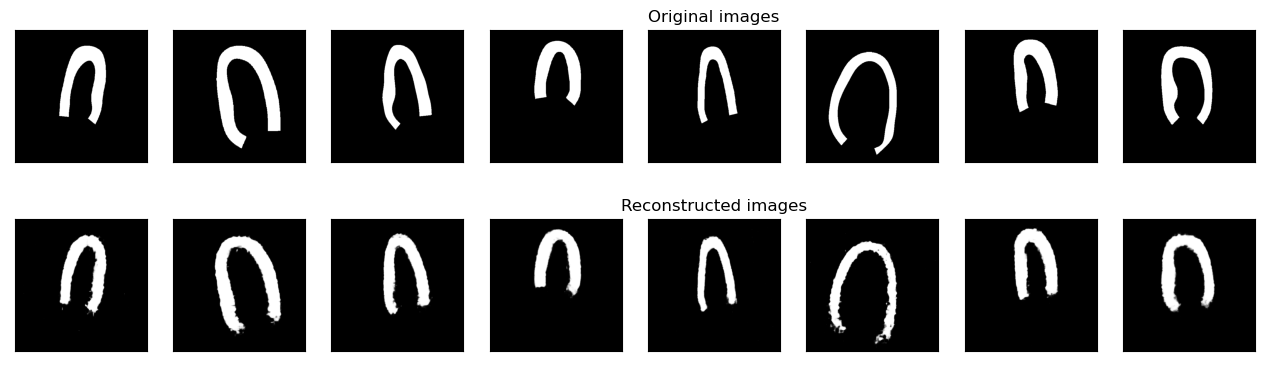


<<<----------------------- EPOCH 7/30 ------------------------->>>
<<<----------------------- MYO ------------------------->>>
Train mean dice: 0.9638
Val mean dice: 0.9203

 MYO train loss=1106.733 	 and 	 MYO val loss=4124.858
Best val DSC: 0.9207 at epoch number of 1


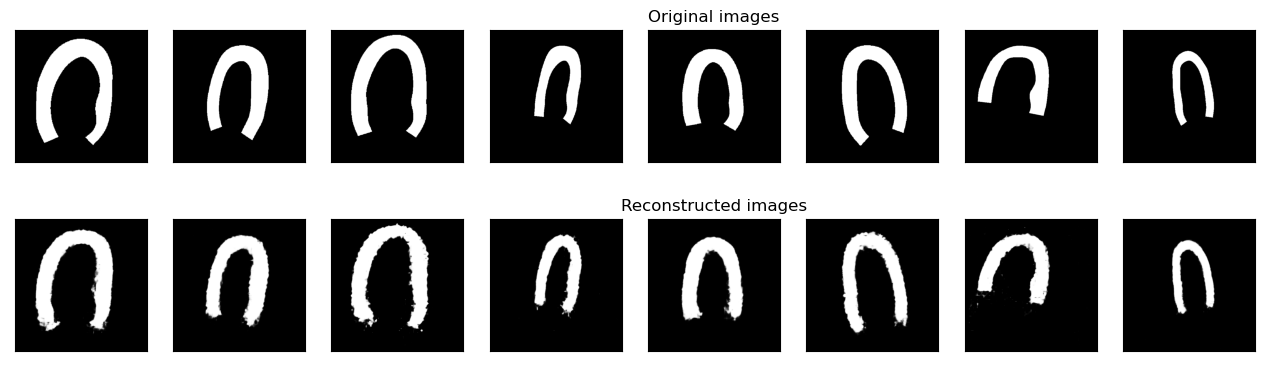


<<<----------------------- EPOCH 8/30 ------------------------->>>
<<<----------------------- MYO ------------------------->>>
Train mean dice: 0.9641
Val mean dice: 0.9184

 MYO train loss=1095.429 	 and 	 MYO val loss=4114.143
Best val DSC: 0.9207 at epoch number of 1


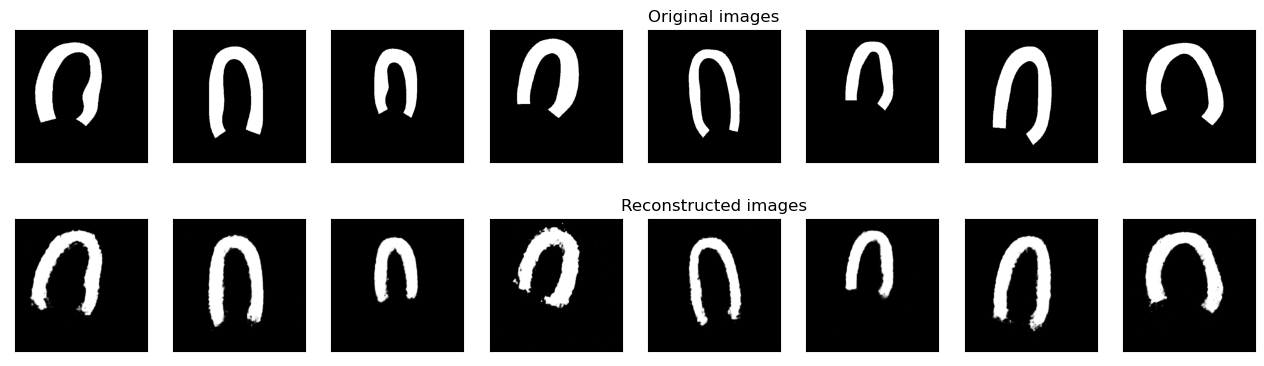


<<<----------------------- EPOCH 9/30 ------------------------->>>
<<<----------------------- MYO ------------------------->>>
Train mean dice: 0.9644
Val mean dice: 0.9186

 MYO train loss=1085.494 	 and 	 MYO val loss=4136.215
Best val DSC: 0.9207 at epoch number of 1


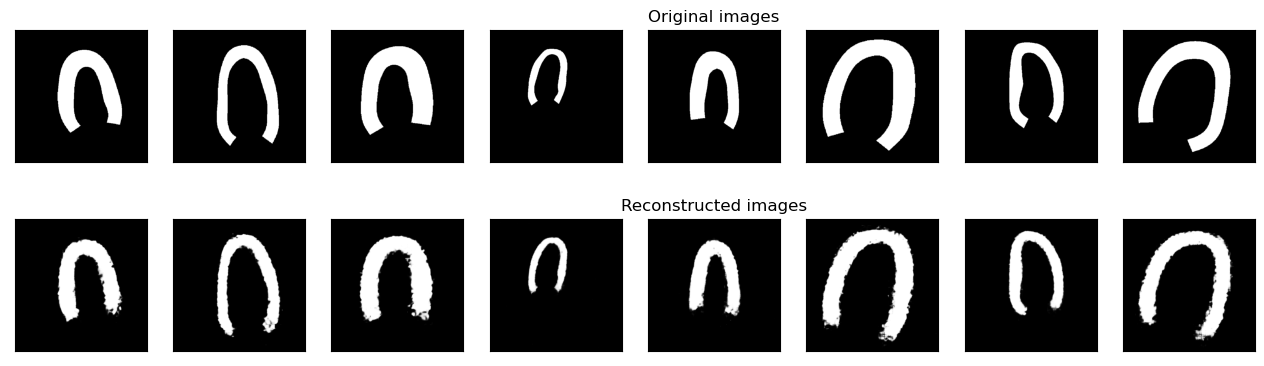


<<<----------------------- EPOCH 10/30 ------------------------->>>
<<<----------------------- MYO ------------------------->>>
Train mean dice: 0.9640
Val mean dice: 0.9205

 MYO train loss=1098.344 	 and 	 MYO val loss=4115.920
Best val DSC: 0.9207 at epoch number of 1


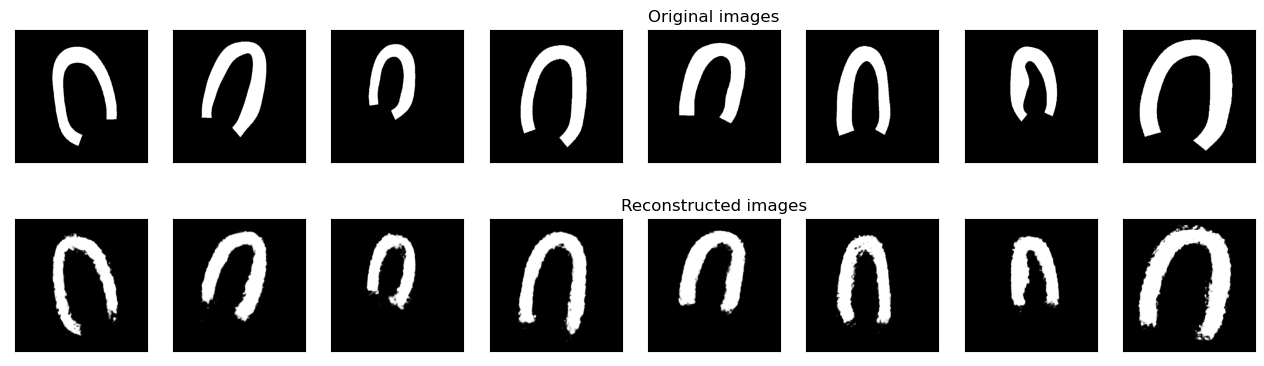


<<<----------------------- EPOCH 11/30 ------------------------->>>
<<<----------------------- MYO ------------------------->>>
Train mean dice: 0.9645
Val mean dice: 0.9206

 MYO train loss=1083.669 	 and 	 MYO val loss=4042.042
Best val DSC: 0.9207 at epoch number of 1


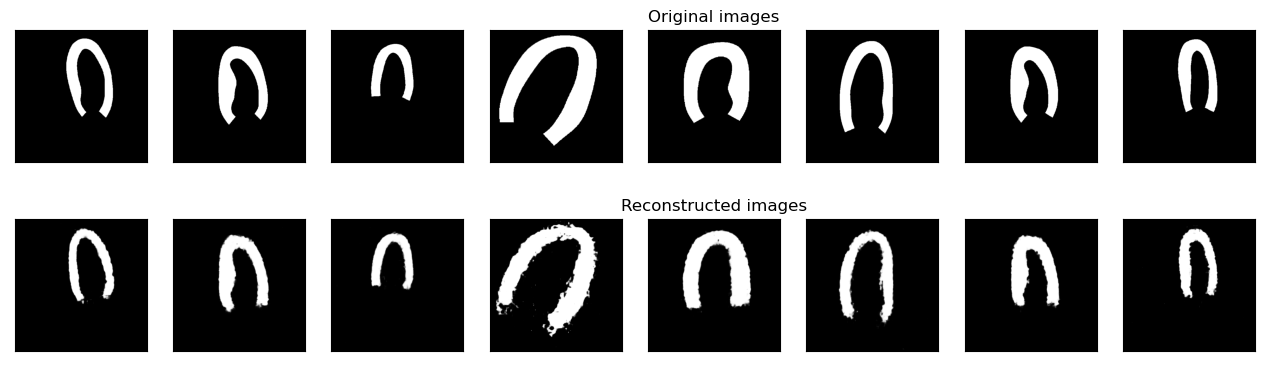


<<<----------------------- EPOCH 12/30 ------------------------->>>
<<<----------------------- MYO ------------------------->>>
Train mean dice: 0.9647
Val mean dice: 0.9206

 MYO train loss=1079.549 	 and 	 MYO val loss=4061.996
Best val DSC: 0.9207 at epoch number of 1


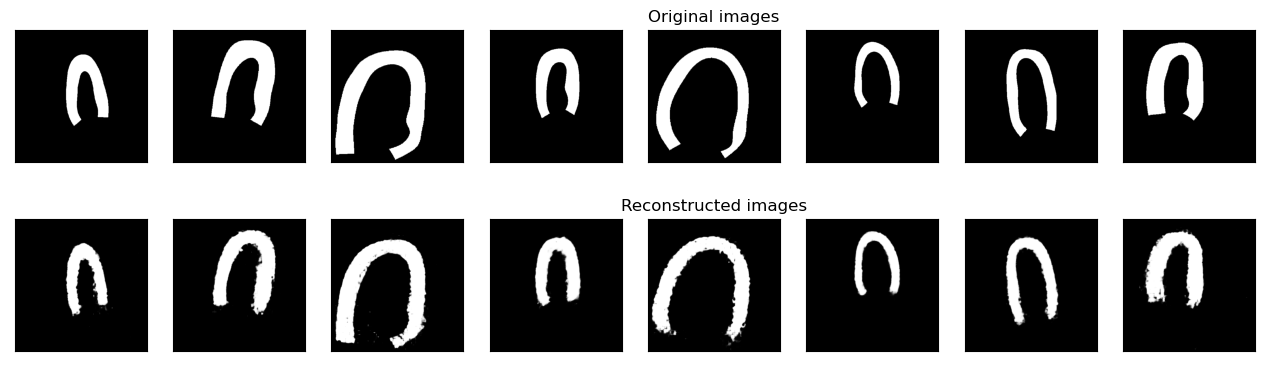


<<<----------------------- EPOCH 13/30 ------------------------->>>
<<<----------------------- MYO ------------------------->>>
Train mean dice: 0.9646
Val mean dice: 0.9203

 MYO train loss=1079.419 	 and 	 MYO val loss=4052.253
Best val DSC: 0.9207 at epoch number of 1


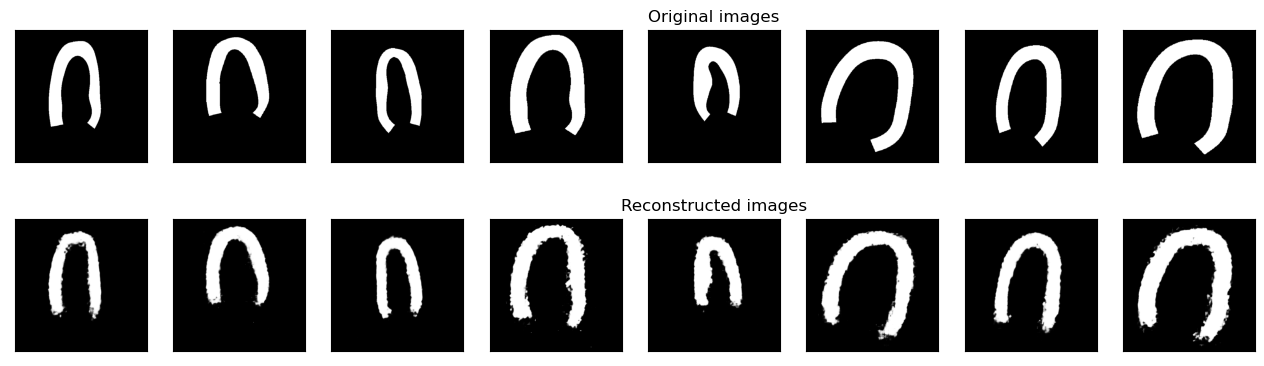


<<<----------------------- EPOCH 14/30 ------------------------->>>
<<<----------------------- MYO ------------------------->>>
Train mean dice: 0.9649
Val mean dice: 0.9203

 MYO train loss=1072.057 	 and 	 MYO val loss=4069.565
Best val DSC: 0.9207 at epoch number of 1


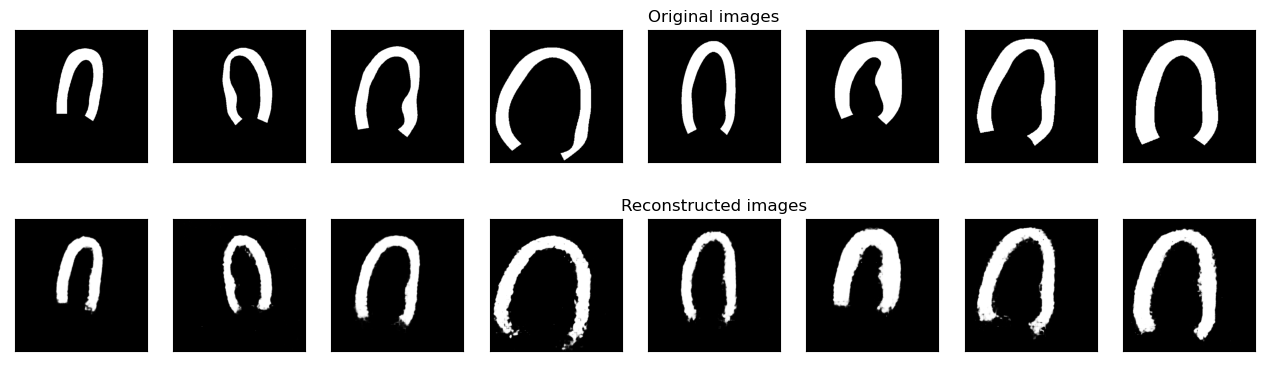


<<<----------------------- EPOCH 15/30 ------------------------->>>
<<<----------------------- MYO ------------------------->>>
Train mean dice: 0.9648
Val mean dice: 0.9210
Valid DSC improved from 0.9207 to 0.9210! Best model is saving as---> Myo_VAE_512_.pth

 MYO train loss=1075.652 	 and 	 MYO val loss=4038.271
Best val DSC: 0.9210 at epoch number of 15


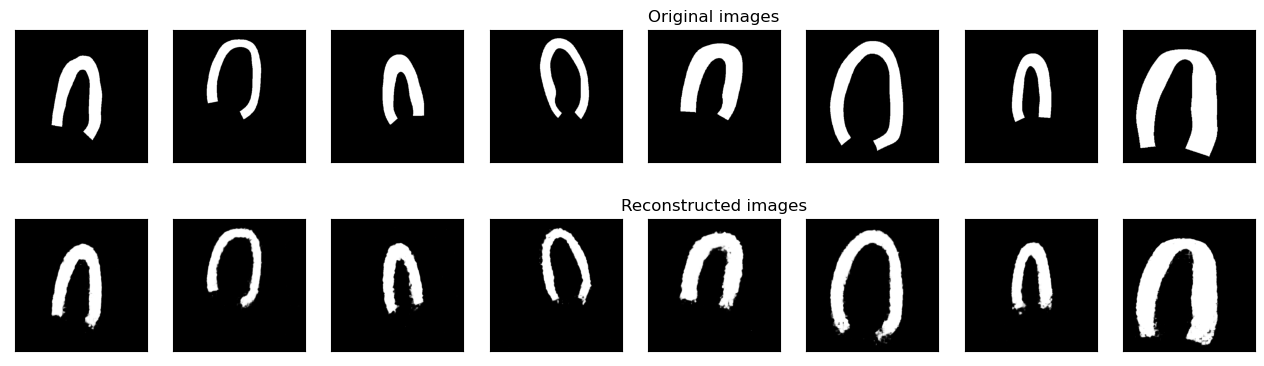


<<<----------------------- EPOCH 16/30 ------------------------->>>
<<<----------------------- MYO ------------------------->>>
Train mean dice: 0.9649
Val mean dice: 0.9210

 MYO train loss=1072.162 	 and 	 MYO val loss=4031.595
Best val DSC: 0.9210 at epoch number of 15


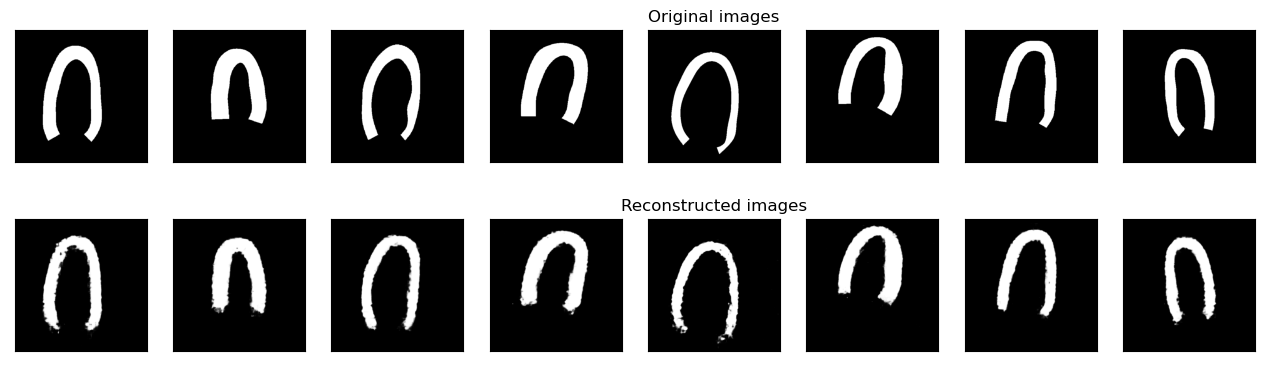


<<<----------------------- EPOCH 17/30 ------------------------->>>
<<<----------------------- MYO ------------------------->>>
Train mean dice: 0.9651
Val mean dice: 0.9210
Valid DSC improved from 0.9210 to 0.9210! Best model is saving as---> Myo_VAE_512_.pth

 MYO train loss=1065.576 	 and 	 MYO val loss=4056.617
Best val DSC: 0.9210 at epoch number of 17


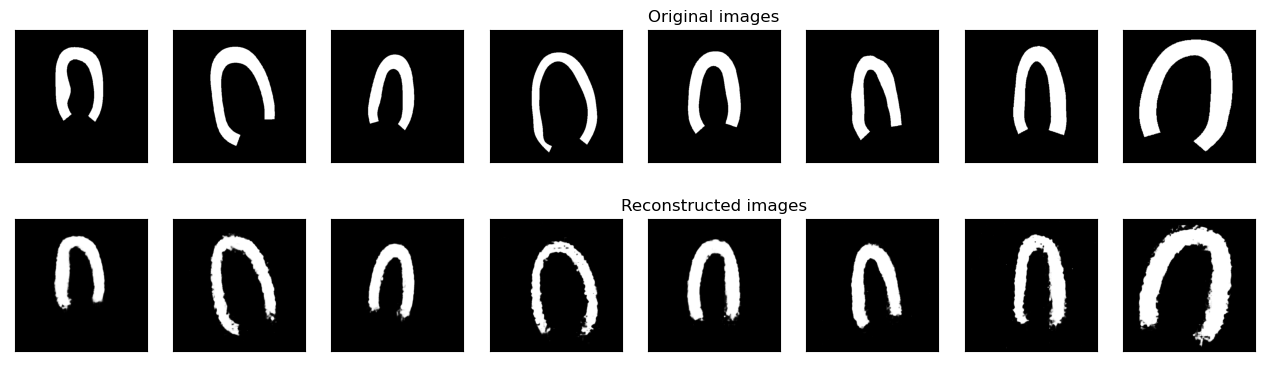


<<<----------------------- EPOCH 18/30 ------------------------->>>
<<<----------------------- MYO ------------------------->>>
Train mean dice: 0.9653
Val mean dice: 0.9203

 MYO train loss=1060.417 	 and 	 MYO val loss=4075.363
Best val DSC: 0.9210 at epoch number of 17


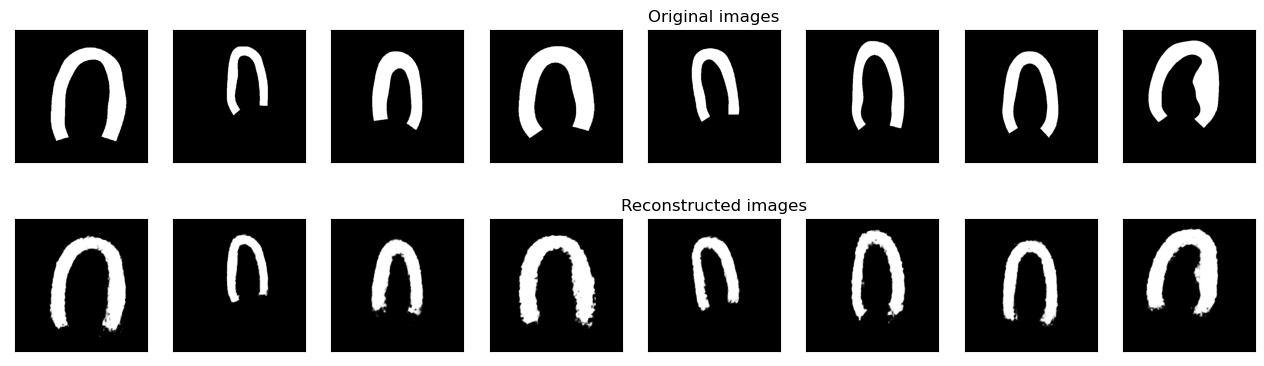


<<<----------------------- EPOCH 19/30 ------------------------->>>
<<<----------------------- MYO ------------------------->>>
Train mean dice: 0.9652
Val mean dice: 0.9205

 MYO train loss=1065.790 	 and 	 MYO val loss=4051.111
Best val DSC: 0.9210 at epoch number of 17


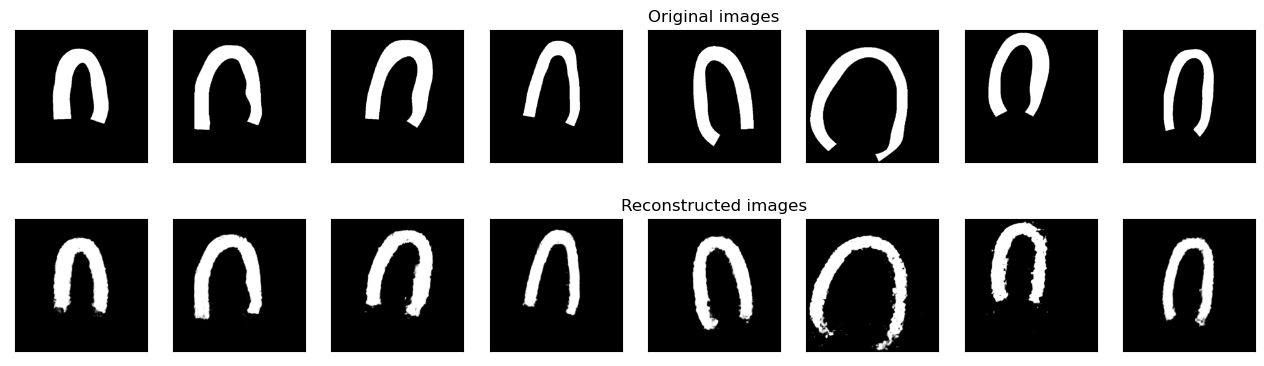


<<<----------------------- EPOCH 20/30 ------------------------->>>
<<<----------------------- MYO ------------------------->>>
Train mean dice: 0.9655
Val mean dice: 0.9198

 MYO train loss=1053.196 	 and 	 MYO val loss=4083.069
Best val DSC: 0.9210 at epoch number of 17


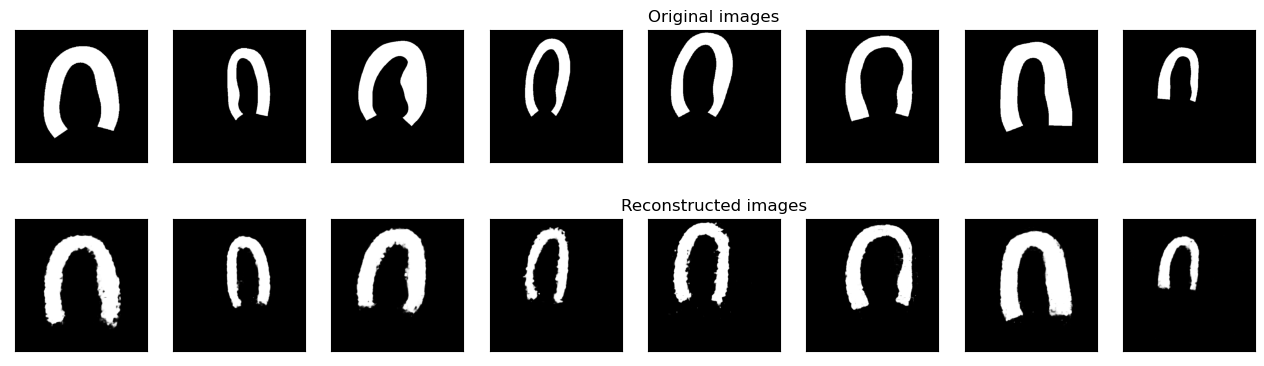


<<<----------------------- EPOCH 21/30 ------------------------->>>
<<<----------------------- MYO ------------------------->>>
Train mean dice: 0.9657
Val mean dice: 0.9219
Valid DSC improved from 0.9210 to 0.9219! Best model is saving as---> Myo_VAE_512_.pth

 MYO train loss=1048.628 	 and 	 MYO val loss=4020.982
Best val DSC: 0.9219 at epoch number of 21


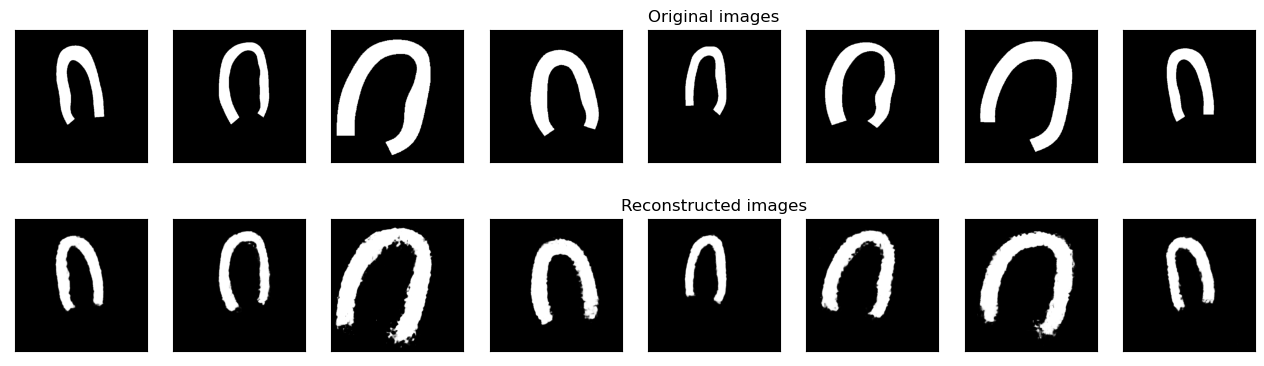


<<<----------------------- EPOCH 22/30 ------------------------->>>
<<<----------------------- MYO ------------------------->>>
Train mean dice: 0.9657
Val mean dice: 0.9216

 MYO train loss=1049.601 	 and 	 MYO val loss=4061.415
Best val DSC: 0.9219 at epoch number of 21


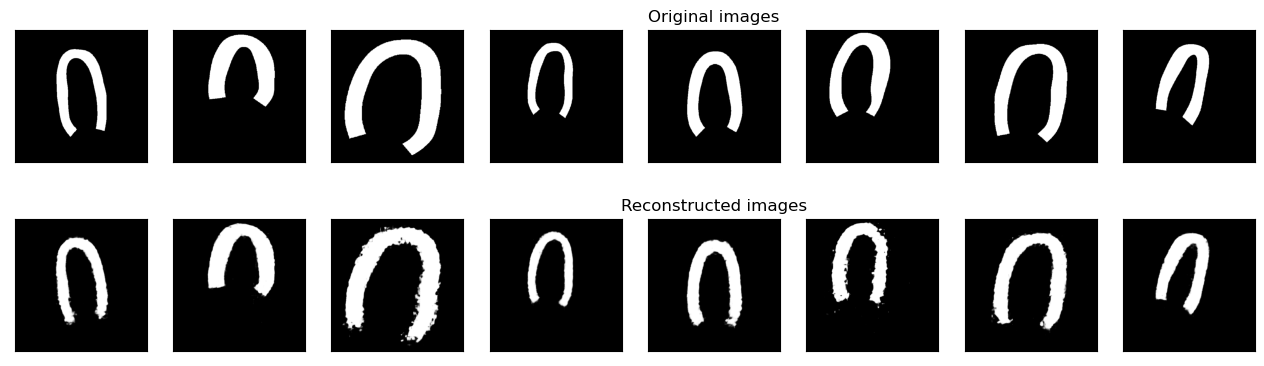


<<<----------------------- EPOCH 23/30 ------------------------->>>
<<<----------------------- MYO ------------------------->>>
Train mean dice: 0.9658
Val mean dice: 0.9211

 MYO train loss=1046.304 	 and 	 MYO val loss=4058.931
Best val DSC: 0.9219 at epoch number of 21


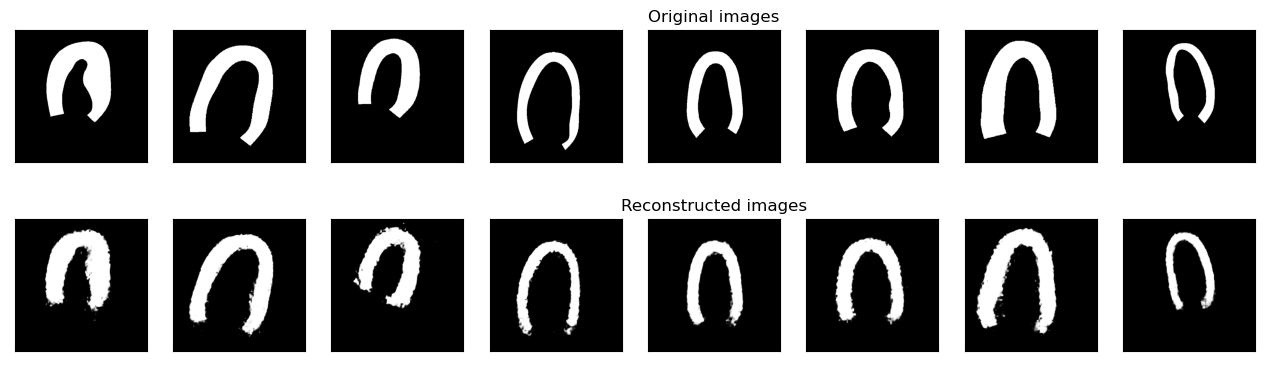


<<<----------------------- EPOCH 24/30 ------------------------->>>
<<<----------------------- MYO ------------------------->>>
Train mean dice: 0.9659
Val mean dice: 0.9207

 MYO train loss=1042.685 	 and 	 MYO val loss=4070.853
Best val DSC: 0.9219 at epoch number of 21


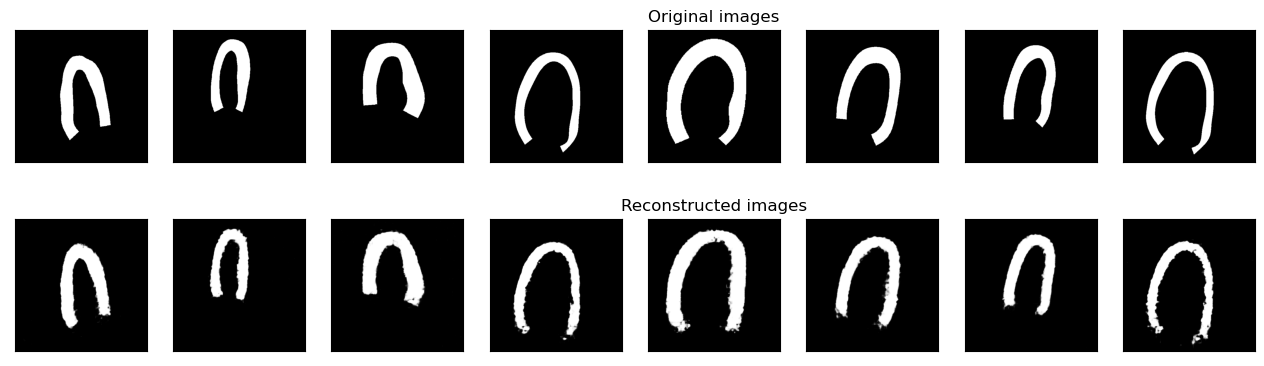


<<<----------------------- EPOCH 25/30 ------------------------->>>
<<<----------------------- MYO ------------------------->>>
Train mean dice: 0.9659
Val mean dice: 0.9214

 MYO train loss=1040.769 	 and 	 MYO val loss=4059.918
Best val DSC: 0.9219 at epoch number of 21


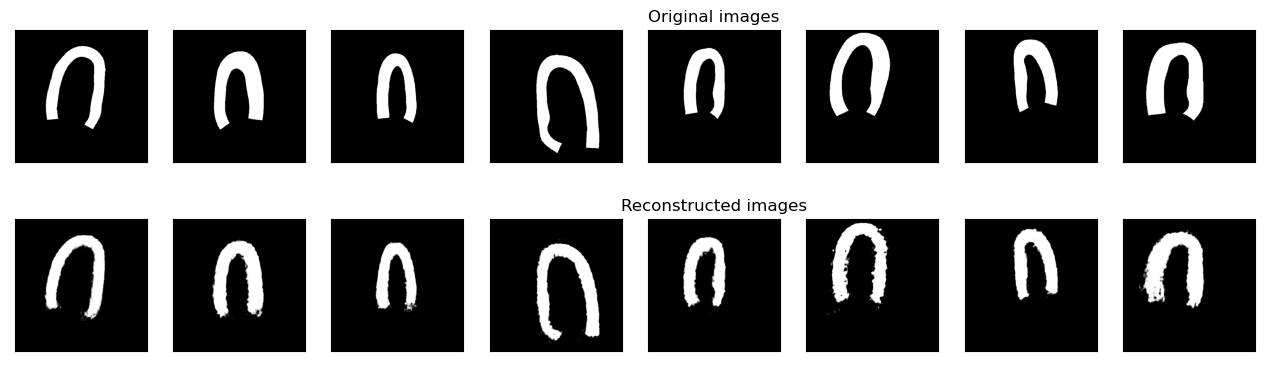


<<<----------------------- EPOCH 26/30 ------------------------->>>
<<<----------------------- MYO ------------------------->>>
Train mean dice: 0.9661
Val mean dice: 0.9215

 MYO train loss=1036.446 	 and 	 MYO val loss=4078.824
Best val DSC: 0.9219 at epoch number of 21


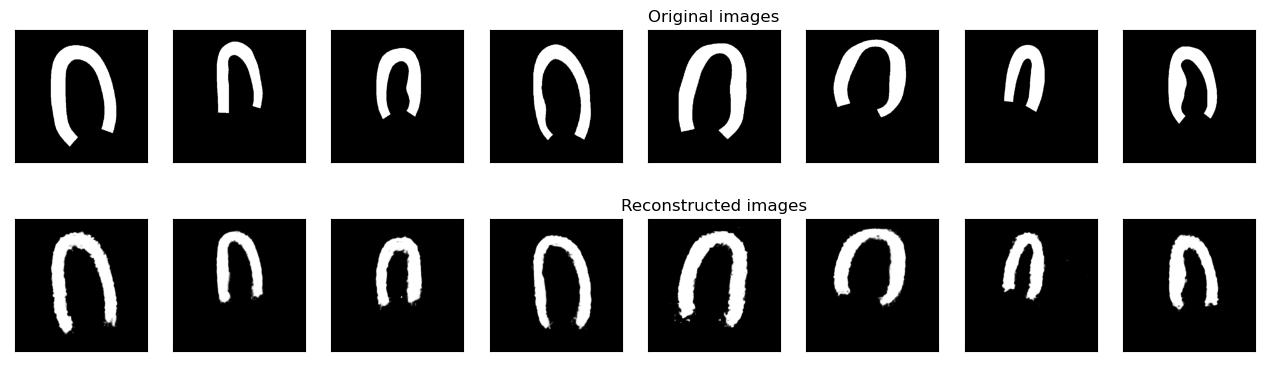


<<<----------------------- EPOCH 27/30 ------------------------->>>
<<<----------------------- MYO ------------------------->>>
Train mean dice: 0.9663
Val mean dice: 0.9217

 MYO train loss=1030.097 	 and 	 MYO val loss=4045.202
Best val DSC: 0.9219 at epoch number of 21


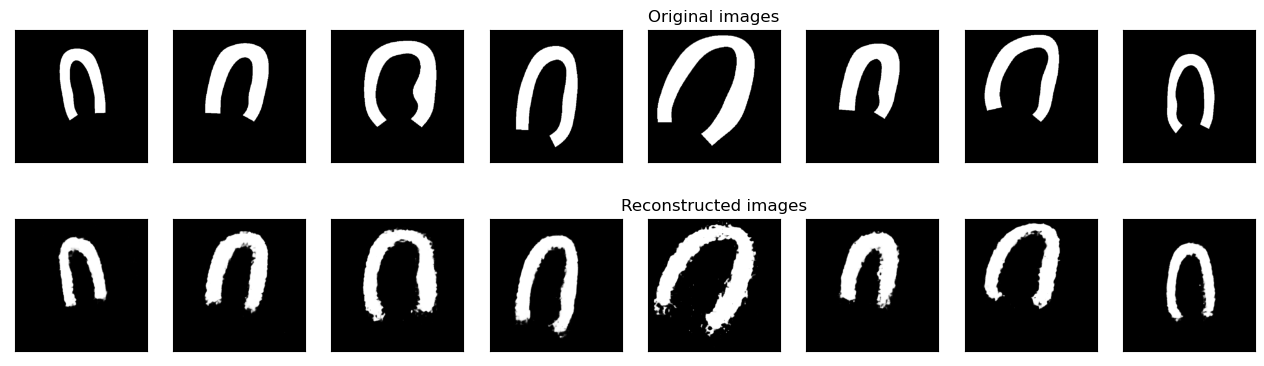


<<<----------------------- EPOCH 28/30 ------------------------->>>
<<<----------------------- MYO ------------------------->>>
Train mean dice: 0.9663
Val mean dice: 0.9206

 MYO train loss=1029.920 	 and 	 MYO val loss=4090.559
Best val DSC: 0.9219 at epoch number of 21


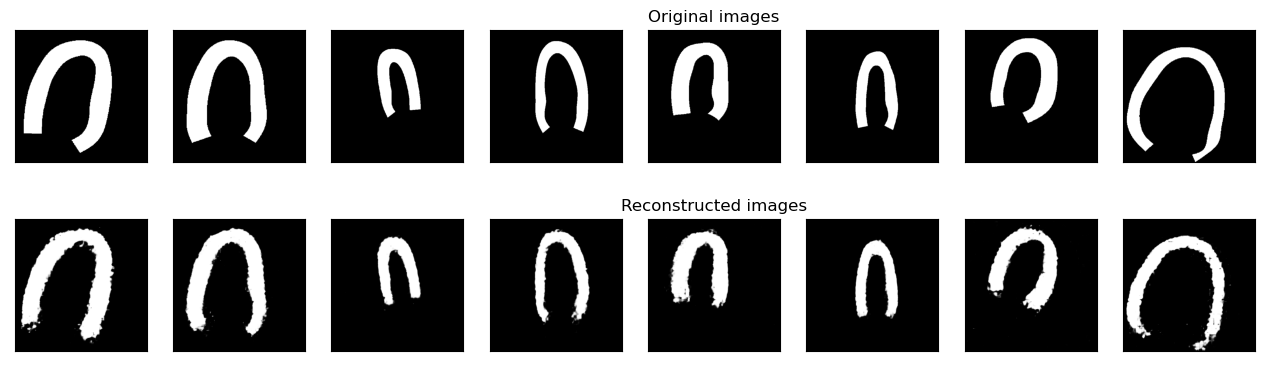


<<<----------------------- EPOCH 29/30 ------------------------->>>
<<<----------------------- MYO ------------------------->>>
Train mean dice: 0.9663
Val mean dice: 0.9208

 MYO train loss=1033.097 	 and 	 MYO val loss=4061.931
Best val DSC: 0.9219 at epoch number of 21


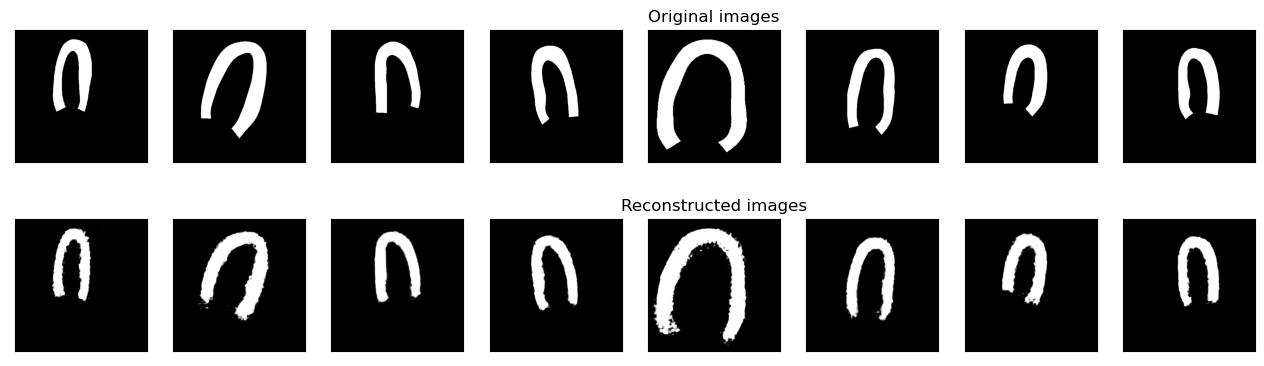


<<<----------------------- EPOCH 30/30 ------------------------->>>
<<<----------------------- MYO ------------------------->>>
Train mean dice: 0.9665
Val mean dice: 0.9220
Valid DSC improved from 0.9219 to 0.9220! Best model is saving as---> Myo_VAE_512_.pth

 MYO train loss=1024.778 	 and 	 MYO val loss=4058.384
Best val DSC: 0.9220 at epoch number of 30


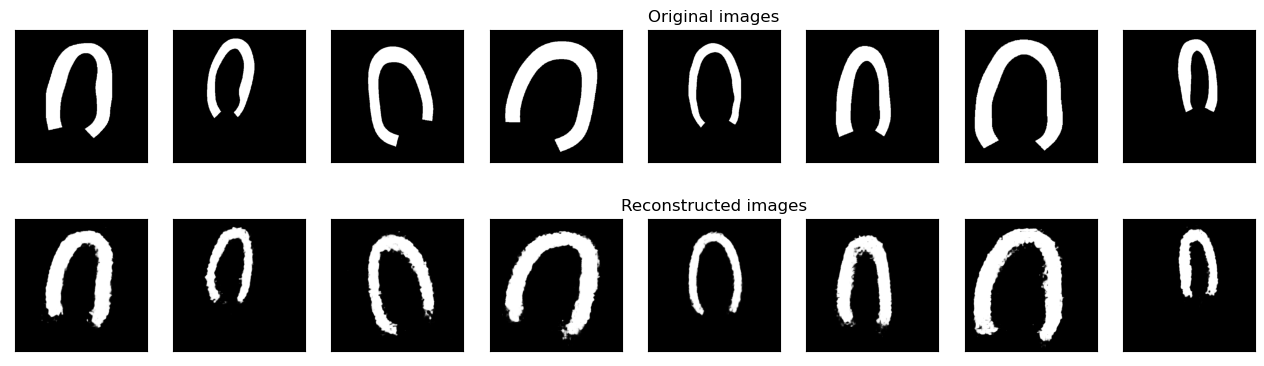

In [16]:
num_epochs = EP

dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

train_Myo_loss_ = []
train_Myo_loss_DSC_ = []
train_Myo_loss_SSIM_ = []
train_Myo_loss_KL_ = []
train_Myo_loss_diff_loss_ = []

val_Myo_loss_ = []
val_Myo_loss_DSC_ = []
val_Myo_loss_SSIM_ = []
val_Myo_loss_KL_ = []
val_Myo_loss_diff_loss_ = []

best_loss = 0

checkpoint_path = 'Myo_VAE_'+ str(img_size) + '_.pth'

for epoch in range(num_epochs):
    print('\n<<<----------------------- EPOCH {}/{} ------------------------->>>'.format(epoch + 1, num_epochs))
    print('<<<----------------------- MYO ------------------------->>>')
    
    MyotrainLoss = train_epoch(Myo_VAE, device, trainData['Myo'], optim_Myo_VAE)
    MyovalLoss = test_epoch(Myo_VAE, device, valData['Myo'])
    
    if MyovalLoss[5] > best_loss:
        best_loss_epoch = epoch + 1
        print(f"Valid DSC improved from {best_loss:2.4f} to {MyovalLoss[5]:2.4f}! Best model is saving as---> {checkpoint_path}")
        best_loss = MyovalLoss[5]
        torch.save(Myo_VAE.state_dict(), checkpoint_path)
    
    print('\n MYO train loss={:.3f} \t and \t MYO val loss={:.3f}'.format(MyotrainLoss[0], MyovalLoss[0]))
    
    print(
    f"Best val DSC: {best_loss:.4f} "
    f"at epoch number of {best_loss_epoch}")
    
    train_Myo_loss_.append(MyotrainLoss[0])
    train_Myo_loss_DSC_.append(MyotrainLoss[1])
    train_Myo_loss_SSIM_.append(MyotrainLoss[2])
    train_Myo_loss_KL_.append(MyotrainLoss[3])
    train_Myo_loss_diff_loss_.append(MyotrainLoss[4])
    
    val_Myo_loss_.append(MyovalLoss[0])
    val_Myo_loss_DSC_.append(MyovalLoss[1])
    val_Myo_loss_SSIM_.append(MyovalLoss[2])
    val_Myo_loss_KL_.append(MyovalLoss[3])
    val_Myo_loss_diff_loss_.append(MyovalLoss[4])
    
    plot_outputs(Myo_VAE.encoder, Myo_VAE.decoder, valData['Myo'])

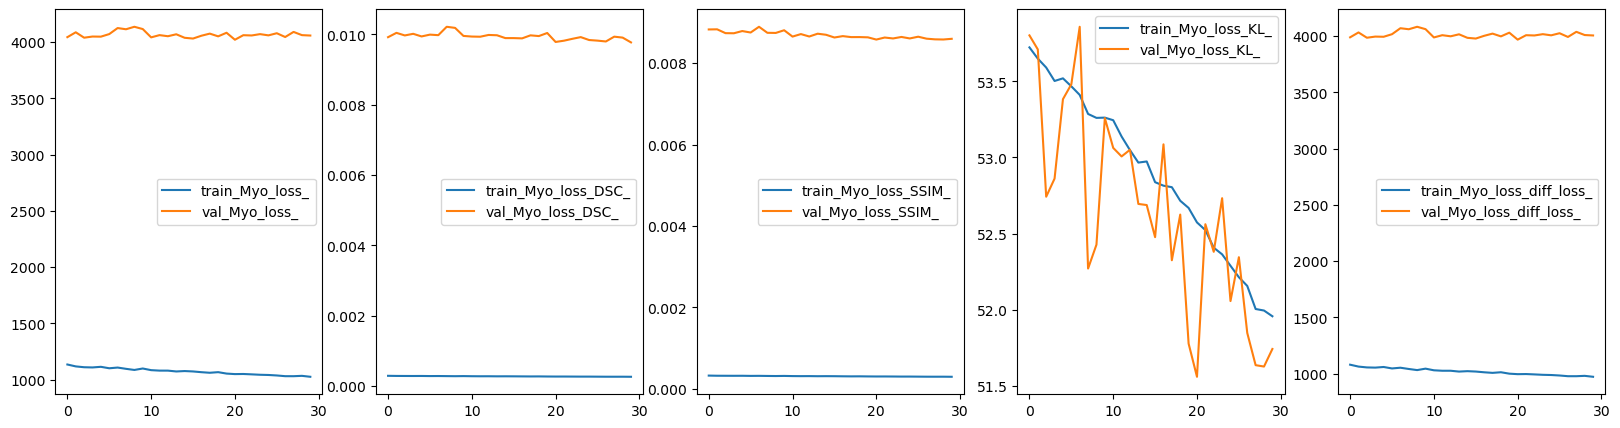

In [17]:
# plot and save the generator and discriminator loss
plt.figure("Myo", (20, 5))
plt.subplot(151)
plt.plot(train_Myo_loss_, label='train_Myo_loss_')
plt.plot(val_Myo_loss_, label='val_Myo_loss_')
plt.legend()

plt.subplot(152)
plt.plot(train_Myo_loss_DSC_, label='train_Myo_loss_DSC_')
plt.plot(val_Myo_loss_DSC_, label='val_Myo_loss_DSC_')
plt.legend()

plt.subplot(153)
plt.plot(train_Myo_loss_SSIM_, label='train_Myo_loss_SSIM_')
plt.plot(val_Myo_loss_SSIM_, label='val_Myo_loss_SSIM_')
plt.legend()

plt.subplot(154)
plt.plot(train_Myo_loss_KL_, label='train_Myo_loss_KL_')
plt.plot(val_Myo_loss_KL_, label='val_Myo_loss_KL_')
plt.legend()

plt.subplot(155)
plt.plot(train_Myo_loss_diff_loss_, label='train_Myo_loss_diff_loss_')
plt.plot(val_Myo_loss_diff_loss_, label='val_Myo_loss_diff_loss_')
plt.legend()